# Netflix movie search

Finding out what to watch is tough choice mainly because of the abundance of options and the scarcity of time.
Let's follow a data-driven approach to arrive at a decision!

In our [dataset](https://www.kaggle.com/datasets/dgoenrique/netflix-movies-and-tv-shows) of movies, we know the
- description,
- genre
- title
- and the release_year
of the movie.

Putting together a vector index on top of these embedded inputs will create a space where we can search semantically to find our movie choice for tonight.

We are going to browse the movies

- searching with an idea (heartfelt romantic comedy)
- tweak around the results giving more imporance to matches in certain input fields
- search in description, genre and title with different search terms for each
- and after finding a close enough movie (that is not quite it), search around utilizing that one, too

## Boilerplate

### Installation

In [1]:
%pip install superlinked==8.6.8

### Imports and constants

In [2]:
from datetime import timedelta, datetime

import altair as alt
import os
import pandas as pd

from superlinked.evaluation.charts.recency_plotter import RecencyPlotter
from superlinked.framework.common.dag.context import CONTEXT_COMMON, CONTEXT_COMMON_NOW
from superlinked.framework.common.dag.period_time import PeriodTime
from superlinked.framework.common.schema.schema import schema
from superlinked.framework.common.schema.schema_object import String, Timestamp
from superlinked.framework.common.schema.id_schema_object import IdField
from superlinked.framework.common.parser.dataframe_parser import DataFrameParser
from superlinked.framework.dsl.executor.in_memory.in_memory_executor import (
    InMemoryExecutor,
    InMemoryApp,
)
from superlinked.framework.dsl.index.index import Index
from superlinked.framework.dsl.query.param import Param
from superlinked.framework.dsl.query.query import Query
from superlinked.framework.dsl.query.result import Result
from superlinked.framework.dsl.source.in_memory_source import InMemorySource
from superlinked.framework.dsl.space.text_similarity_space import TextSimilaritySpace
from superlinked.framework.dsl.space.recency_space import RecencySpace

alt.renderers.enable("mimetype")
alt.data_transformers.disable_max_rows()
pd.set_option("display.max_colwidth", 190)

In [3]:
YEAR_IN_DAYS = 365
TOP_N = 10
DATASET_URL = "https://storage.googleapis.com/superlinked-notebook-netflix-shows-dataset/titles.csv"
# as our latest movie is from 2022 we can set this as the time of the analysis
END_OF_2022_TS = int(datetime(2022, 12, 31, 23, 59).timestamp())
EXECUTOR_DATA = {CONTEXT_COMMON: {CONTEXT_COMMON_NOW: END_OF_2022_TS}}

## Prepare dataset

In [4]:
NROWS = os.getenv("NOTEBOOK_TEST_ROW_LIMIT", None)
NROWS = NROWS if NROWS is None else int(NROWS)
movie_df = pd.read_csv(DATASET_URL, nrows=NROWS)
# keep only relevant columns
movie_df = (
    movie_df[["description", "genres", "title", "release_year", "id"]]
    .drop_duplicates(subset=["description"])
    .dropna(how="any")
)
# join genres to create a textual column
movie_df["genres"] = movie_df["genres"].apply(lambda x: " ".join(eval(x)))
# convert release year to a timestamp - always the 1st of January
movie_df["timestamp"] = [
    int(pd.Timestamp(year=year, month=1, day=1).timestamp())
    for year in movie_df["release_year"].tolist()
]
movie_df.head()

,description,genres,title,release_year,id,timestamp
0,"This collection includes 12 World War II-era propaganda films — many of which are graphic and offensive — discussed in the docuseries ""Five Came Back.""",documentation,Five Came Back: The Reference Films,1945,ts300399,-788918400.0
1,A mentally unstable Vietnam War veteran works as a night-time taxi driver in New York City where the perceived decadence and sleaze feed his urge for violent action.,drama crime,Taxi Driver,1976,tm84618,189302400.0
2,"Intent on seeing the Cahulawassee River before it's turned into one huge lake, outdoor fanatic Lewis Medlock takes his friends on a river-rafting trip they'll never forget into the dange...",drama action thriller european,Deliverance,1972,tm154986,63072000.0
3,"King Arthur, accompanied by his squire, recruits his Knights of the Round Table, including Sir Bedevere the Wise, Sir Lancelot the Brave, Sir Robin the Not-Quite-So-Brave-As-Sir-Lancelot...",fantasy action comedy,Monty Python and the Holy Grail,1975,tm127384,157766400.0
4,"12 American military prisoners in World War II are ordered to infiltrate a well-guarded enemy château and kill the Nazi officers vacationing there. The soldiers, most of whom are facing ...",war action,The Dirty Dozen,1967,tm120801,-94694400.0


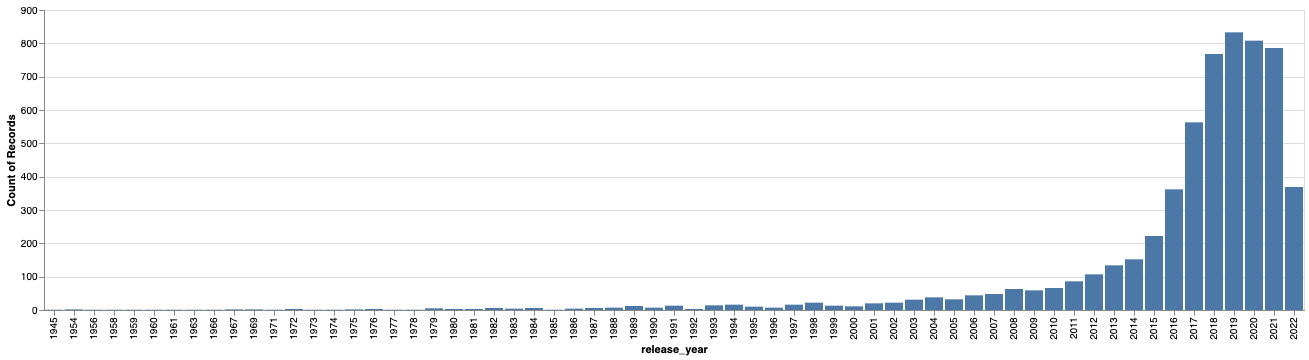

In [5]:
# let's use 4, 10 and 40 years as our period times so that populous areas get more focus
alt.Chart(movie_df[["release_year"]].astype(str)).mark_bar().encode(
    x=alt.X("release_year"), y="count()"
)

## Set up Superlinked

In [6]:
# accommodate our inputs in a typed schema
@schema
class MovieSchema:
    description: String
    title: String
    release_timestamp: Timestamp
    genres: String
    id: IdField

In [7]:
movie = MovieSchema()

In [8]:
# textual fields are embedded using a sentence-transformers model
description_space = TextSimilaritySpace(
    text=movie.description, model="sentence-transformers/paraphrase-MiniLM-L3-v2"
)
title_space = TextSimilaritySpace(
    text=movie.title, model="sentence-transformers/paraphrase-MiniLM-L3-v2"
)
genre_space = TextSimilaritySpace(
    text=movie.genres, model="sentence-transformers/paraphrase-MiniLM-L3-v2"
)
# release date are encoded using our recency space
# periodtimes aim to reflect notable breaks in our scores
recency_space = RecencySpace(
    timestamp=movie.release_timestamp,
    period_time_list=[
        PeriodTime(timedelta(days=4 * YEAR_IN_DAYS)),
        PeriodTime(timedelta(days=10 * YEAR_IN_DAYS)),
        PeriodTime(timedelta(days=40 * YEAR_IN_DAYS)),
    ],
    negative_filter=-0.25,
)

In [9]:
movie_index = Index(spaces=[description_space, title_space, genre_space, recency_space])

In [10]:
query_text_param = Param("query_text")

simple_query = (
    Query(
        movie_index,
        weights={
            description_space: Param("description_weight"),
            title_space: Param("title_weight"),
            genre_space: Param("genre_weight"),
            recency_space: Param("recency_weight"),
        },
    )
    .find(movie)
    .similar(description_space.text, query_text_param)
    .similar(title_space.text, query_text_param)
    .similar(genre_space.text, query_text_param)
    .limit(Param("limit"))
)

advanced_query = (
    Query(
        movie_index,
        weights={
            description_space: Param("description_weight"),
            title_space: Param("title_weight"),
            genre_space: Param("genre_weight"),
            recency_space: Param("recency_weight"),
        },
    )
    .find(movie)
    .similar(description_space.text, Param("description_query_text"))
    .similar(title_space.text, Param("title_query_text"))
    .similar(genre_space.text, Param("genre_query_text"))
    .limit(Param("limit"))
)

In [11]:
df_parser = DataFrameParser(
    schema=movie, mapping={movie.release_timestamp: "timestamp"}
)

In [12]:
source: InMemorySource = InMemorySource(movie, parser=df_parser)
executor: InMemoryExecutor = InMemoryExecutor(
    sources=[source], indices=[movie_index], context_data=EXECUTOR_DATA
)
app: InMemoryApp = executor.run()

In [13]:
source.put([movie_df])

## Understanding recency

Recency can seem quite complex at first, let's see how the score looks like for the relevant time periods

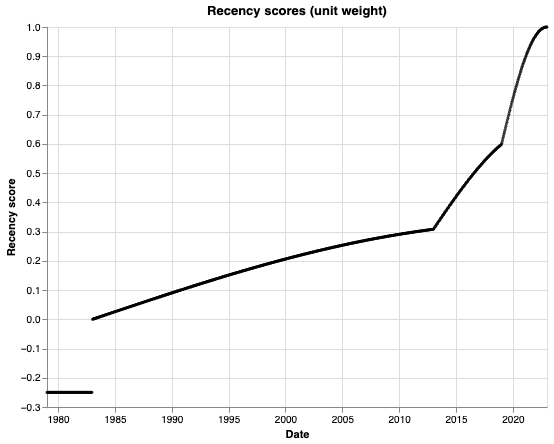

In [14]:
recency_plotter = RecencyPlotter(recency_space, context_data=EXECUTOR_DATA)
chart = recency_plotter.plot_recency_curve()
chart

notice the breaks in the score at 4, 10 and 40 years - those are our period times. Titles older than 40 years get `negative_filter` score.

## Run queries

Let's define a quick util function to present our results in the notebook

In [15]:
def present_result(
    result: Result,
    cols_to_keep: list[str] = ["description", "title", "genres", "release_year", "id"],
) -> pd.DataFrame:
    # parse result to dataframe
    df: pd.DataFrame = result.to_pandas()
    # transform timestamp back to release year
    df["release_year"] = [
        datetime.fromtimestamp(timestamp).year for timestamp in df["release_timestamp"]
    ]
    return df[cols_to_keep]

### Search with user queries

With the simple query, I can search with my text in all of the fields

In [16]:
result: Result = app.query(
    simple_query,
    query_text="Heartfelt romantic comedy",
    description_weight=1,
    title_weight=1,
    genre_weight=1,
    recency_weight=0,
    limit=TOP_N,
)

present_result(result)

,description,title,genres,release_year,id
0,"When a group of people meets at the same party, they form four different relationships, each experiencing similar phases of love.","Love, Surreal and Odd",comedy romance,2017,tm313118
1,"An LA girl, unlucky in love, falls for an East Coast guy on a dating app and decides to surprise him for the holidays, only to discover that she's been catfished. This lighthearted roman...",Love Hard,romance comedy,2021,tm1093099
2,Romantic anthology web series revolving around 12 stories of 12 months of young people on their paths to love.,Love Daily,drama romance,2018,ts90869
3,"In this romantic comedy, several friends, each dealing with unhappy love lives, turn to each other for help - but not always with the best results.",F*ck Love Too,comedy romance,2022,tm1203307
4,Aspiring pop star Erica ends up as the entertainment at her ex-fiancé’s wedding after reluctantly taking a gig at a luxurious island resort while in the wake of a music career meltdown.,Resort to Love,romance comedy,2021,tm1037704
5,"'Love Actually' follows the lives of eight very different couples dealing with their love lives, in various loosely and interrelated tales, all set during a frantic month before Christma...",Love Actually,drama comedy romance,2003,tm133767
6,Exploration into the tense relationship of success and romance.,Love or Money,romance,2021,tm997617
7,"It tells the love story of two childhood sweethearts that spans 19 years. Chen Xiao Xi is a cute and small girl with a lot of positive energy. She gets to know Jiang Chen, a tall and pro...",A Love So Beautiful,comedy romance,2017,ts77034
8,Rebellious Mickey and good-natured Gus navigate the thrills and agonies of modern relationships.,Love,comedy drama romance,2016,ts38511
9,"A young woman develops romantic feelings for her best friend, but problems arise when another gal enters the picture.",Must Be... Love,comedy romance,2013,tm188290


After looking at the results, I see some titles I have already seen. I can bias towards recent titles by upweighting recency. Weights are normalized to have unit sum, so you don't have to worry about how you set them.

In [17]:
result: Result = app.query(
    simple_query,
    query_text="Heartfelt romantic comedy",
    description_weight=1,
    title_weight=1,
    genre_weight=1,
    recency_weight=3,
    limit=TOP_N,
)

present_result(result)

,description,title,genres,release_year,id
0,"In this romantic comedy, several friends, each dealing with unhappy love lives, turn to each other for help - but not always with the best results.",F*ck Love Too,comedy romance,2022,tm1203307
1,"Fidelity tells a story of marital fidelity, in particular the one of Carlo and Margherita, a young couple who needs to face the deflagrant consequences of an alleged betrayal. Their rela...","Devotion, a Story of Love and Desire",drama romance,2022,ts280892
2,This black humor pan-Arabic anthology series is about love in general – and relationships in particular.,"Love, Life & Everything in Between",comedy drama romance,2022,ts329711
3,"A relatable romance drama about a couple in their 30s preparing for marriage. While they were expecting a happy ending like something out of a fairy tale, the reality of their preparatio...",Welcome to Wedding Hell,drama romance,2022,ts344043
4,"An ad executive and a fashion designer-blogger don't believe in love, so they place a bet to make the other fall head over heels - with unusual tactics.",Love Tactics,comedy romance,2022,tm1152224
5,"Often (mis)guided by a cheeky imaginary wizard, an awkward and lonely 20-something struggles to get out of his own way in his quest for a girlfriend.",Eternally Confused and Eager for Love,comedy romance,2022,ts330012
6,"Guille decides it's time to take the next step and that's how she looks to marry her sweetheart, but things get complicated and nothing goes as planned.","Let's Tie the Knot, Honey!",comedy romance,2022,tm1204412
7,"A modern love story set in the near future where an AI building is powered by human feelings. Due to a software glitch, it falls in love with a real girl, escapes the building into the b...",AI Love You,scifi comedy romance drama,2022,tm1160424
8,"After his ad agency goes bankrupt, an indebted Fırat falls for a singer at a yoga retreat and joins her on a journey of self-realization.",Doom of Love,romance drama,2022,tm1218702
9,A wife who feels suffocated by her husband's incessant attention hires a psychologist to make him fall in love with her so that she can separate from him.,Hey! Sinamika,drama romance,2022,tm1143258


Still using the simple query, I can give more weight to spaces if I think my query is more related to that space - matches there should count more. Here I give additional weight to the genre, leave the description as is, and downweight the title as my query text is mostly a genre with some additional context. I keep recency with unit weight too, as I would like my results to be a bit biased towards recent movies.

In [18]:
result = app.query(
    simple_query,
    query_text="Heartfelt romantic comedy",
    description_weight=1,
    title_weight=0.1,
    genre_weight=2,
    recency_weight=1,
    limit=TOP_N,
)

present_result(result)

,description,title,genres,release_year,id
0,"In this romantic comedy, several friends, each dealing with unhappy love lives, turn to each other for help - but not always with the best results.",F*ck Love Too,comedy romance,2022,tm1203307
1,"An LA girl, unlucky in love, falls for an East Coast guy on a dating app and decides to surprise him for the holidays, only to discover that she's been catfished. This lighthearted roman...",Love Hard,romance comedy,2021,tm1093099
2,"A relatable romance drama about a couple in their 30s preparing for marriage. While they were expecting a happy ending like something out of a fairy tale, the reality of their preparatio...",Welcome to Wedding Hell,drama romance,2022,ts344043
3,This black humor pan-Arabic anthology series is about love in general – and relationships in particular.,"Love, Life & Everything in Between",comedy drama romance,2022,ts329711
4,"In this rom-com challenging the concept of soulmates, parallel storylines portray four single friends as they pair up in different couple combinations.",Four to Dinner,comedy romance,2022,tm1137862
5,"Guille decides it's time to take the next step and that's how she looks to marry her sweetheart, but things get complicated and nothing goes as planned.","Let's Tie the Knot, Honey!",comedy romance,2022,tm1204412
6,Short films follow young adults as they navigate the gamut of emotions that come with finding romantic connection in unexpected places.,Feels Like Ishq,drama romance comedy,2021,ts283610
7,"An ad executive and a fashion designer-blogger don't believe in love, so they place a bet to make the other fall head over heels - with unusual tactics.",Love Tactics,comedy romance,2022,tm1152224
8,Incurable romantic Lotte's life is upended when her plans for a picture-perfect wedding unravel--just as her self-absorbed sister gets engaged.,Just Say Yes,comedy romance,2021,tm904862
9,"In pursuit of both success and validation, a group of tech-savvy individuals juggle intimate encounters, first impressions and romantic opportunities.",Slay,romance comedy,2021,tm1038025


With the advanced query, I can even supply different search terms for each attribute of the movie.

In [19]:
result = app.query(
    advanced_query,
    description_query_text="Heartfelt lovely romantic comedy for a cold autumn evening.",
    title_query_text="love",
    genre_query_text="drama comedy romantic",
    description_weight=1,
    title_weight=1,
    genre_weight=1,
    recency_weight=0,
    limit=TOP_N,
)

present_result(result)

,description,title,genres,release_year,id
0,"'Love Actually' follows the lives of eight very different couples dealing with their love lives, in various loosely and interrelated tales, all set during a frantic month before Christma...",Love Actually,drama comedy romance,2003,tm133767
1,Rebellious Mickey and good-natured Gus navigate the thrills and agonies of modern relationships.,Love,comedy drama romance,2016,ts38511
2,"An LA girl, unlucky in love, falls for an East Coast guy on a dating app and decides to surprise him for the holidays, only to discover that she's been catfished. This lighthearted roman...",Love Hard,romance comedy,2021,tm1093099
3,A rising black painter tries to break into a competitive art world while balancing an unexpected romance with an ambitious law student.,Really Love,romance drama,2020,tm946360
4,Romantic anthology web series revolving around 12 stories of 12 months of young people on their paths to love.,Love Daily,drama romance,2018,ts90869
5,"Adam and Marklin’s 5-year relationship has gone from a passionate flame to a simmer, forcing them to reconcile with each other’s shortcomings while their friends endlessly search for lov...",Almost Love,comedy drama romance,2019,tm472195
6,"Love is as tough as it is sweet for a lovestruck teenager, whose relationship with her next-door neighbor transforms as they grow into adulthood.",A Love So Beautiful,comedy drama,2020,ts357033
7,"Near by Christmas, in an old and charming town in Transylvania, Sebastian and Aprilia start a beautiful love story. However, nothing is as simple as it would seem. Being influenced by th...",Love Is a Story,romance european comedy,2015,tm368725
8,This black humor pan-Arabic anthology series is about love in general – and relationships in particular.,"Love, Life & Everything in Between",comedy drama romance,2022,ts329711
9,Laida Magtalas is a modern-day Belle who works hard to provide for her family while hoping that someday she will meet her prince charming and that they will live happily ever after toget...,A Very Special Love,comedy drama romance,2008,tm28024


And even give different weights to each subsearch if I really do care that the title is related to love but I am not really emotionally attached to my description of the movie I would want to see.

In [20]:
result = app.query(
    advanced_query,
    description_query_text="Heartfelt lovely romantic comedy for a cold autumn evening.",
    title_query_text="love",
    genre_query_text="drama comedy romantic",
    description_weight=0.2,
    title_weight=3,
    genre_weight=1,
    recency_weight=0,
    limit=TOP_N,
)

present_result(result)

,description,title,genres,release_year,id
0,Rebellious Mickey and good-natured Gus navigate the thrills and agonies of modern relationships.,Love,comedy drama romance,2016,ts38511
1,The story of a family and the various situations navigated by a husband and wife.,Love,thriller drama,2020,tm946277
2,"'Love Actually' follows the lives of eight very different couples dealing with their love lives, in various loosely and interrelated tales, all set during a frantic month before Christma...",Love Actually,drama comedy romance,2003,tm133767
3,A rising black painter tries to break into a competitive art world while balancing an unexpected romance with an ambitious law student.,Really Love,romance drama,2020,tm946360
4,"Adam and Marklin’s 5-year relationship has gone from a passionate flame to a simmer, forcing them to reconcile with each other’s shortcomings while their friends endlessly search for lov...",Almost Love,comedy drama romance,2019,tm472195
5,"The story of Richard and Mildred Loving, an interracial couple, whose challenge of their anti-miscegenation arrest for their marriage in Virginia led to a legal battle that would end at ...",Loving,drama romance,2016,tm219233
6,"An LA girl, unlucky in love, falls for an East Coast guy on a dating app and decides to surprise him for the holidays, only to discover that she's been catfished. This lighthearted roman...",Love Hard,romance comedy,2021,tm1093099
7,"In order to receive a bone marrow transplant quicker and be able to continue her career as an actress, Xia Lin enters into a secret marriage with Ling Yi Zhou, the CEO of a company. Desp...",Well-Intended Love,drama romance,2019,ts88133
8,"It tells the love story of two childhood sweethearts that spans 19 years. Chen Xiao Xi is a cute and small girl with a lot of positive energy. She gets to know Jiang Chen, a tall and pro...",A Love So Beautiful,comedy romance,2017,ts77034
9,"Love is as tough as it is sweet for a lovestruck teenager, whose relationship with her next-door neighbor transforms as they grow into adulthood.",A Love So Beautiful,comedy drama,2020,ts357033


Then I can bias again towards recent movies

In [21]:
result = app.query(
    advanced_query,
    description_query_text="Heartfelt lovely romantic comedy for a cold autumn evening.",
    title_query_text="love",
    genre_query_text="drama comedy romantic",
    description_weight=0.2,
    title_weight=3,
    genre_weight=1,
    recency_weight=5,
    limit=TOP_N,
)

present_result(result)

,description,title,genres,release_year,id
0,"After his ad agency goes bankrupt, an indebted Fırat falls for a singer at a yoga retreat and joins her on a journey of self-realization.",Doom of Love,romance drama,2022,tm1218702
1,"An ad executive and a fashion designer-blogger don't believe in love, so they place a bet to make the other fall head over heels - with unusual tactics.",Love Tactics,comedy romance,2022,tm1152224
2,"Fidelity tells a story of marital fidelity, in particular the one of Carlo and Margherita, a young couple who needs to face the deflagrant consequences of an alleged betrayal. Their rela...","Devotion, a Story of Love and Desire",drama romance,2022,ts280892
3,This black humor pan-Arabic anthology series is about love in general – and relationships in particular.,"Love, Life & Everything in Between",comedy drama romance,2022,ts329711
4,"A modern love story set in the near future where an AI building is powered by human feelings. Due to a software glitch, it falls in love with a real girl, escapes the building into the b...",AI Love You,scifi comedy romance drama,2022,tm1160424
5,"Often (mis)guided by a cheeky imaginary wizard, an awkward and lonely 20-something struggles to get out of his own way in his quest for a girlfriend.",Eternally Confused and Eager for Love,comedy romance,2022,ts330012
6,"An LA girl, unlucky in love, falls for an East Coast guy on a dating app and decides to surprise him for the holidays, only to discover that she's been catfished. This lighthearted roman...",Love Hard,romance comedy,2021,tm1093099
7,"Haruto Asakura falls in love with hairdresser Misaki Ariake and asks her out. Watching Misaki Ariake work hard to achieve what she wants, Haruto Asakura, who almost gave up his dream to ...",Love Like the Falling Petals,drama romance,2022,tm1119015
8,"Inside a national weather service, love proves just as difficult to predict as rain or shine for a diligent forecaster and her free-spirited co-worker.",Forecasting Love and Weather,drama romance,2022,ts319412
9,"In this romantic comedy, several friends, each dealing with unhappy love lives, turn to each other for help - but not always with the best results.",F*ck Love Too,comedy romance,2022,tm1203307


Or maybe to older ones

In [22]:
result = app.query(
    advanced_query,
    description_query_text="Heartfelt lovely romantic comedy for a cold autumn evening.",
    title_query_text="love",
    genre_query_text="drama comedy romantic",
    description_weight=0.2,
    title_weight=3,
    genre_weight=1,
    recency_weight=-10,
    limit=TOP_N,
)

present_result(result)

,description,title,genres,release_year,id
0,"Two young kids fall in love with each other. But the passion is too consuming for the parents of Jade. The parents try to stop them from seeing each other. But when this doesn't work, Da...",Endless Love,romance drama,1981,tm130586
1,"Anil, a street singer, is humiliated and driven out of Bombay along with his mother. However, he soon becomes a famous performer but the enemies from his past try to destroy his hard-ear...",Disco Dancer,drama romance,1982,tm52815
2,"An honest man dreams of a better life for his family, but a childhood friend leads him into a world of crime that keeps happiness just out of reach.",Ujala,romance crime drama,1959,tm358653
3,Two talented song-and-dance men team up after the war to become one of the hottest acts in show business. In time they befriend and become romantically involved with the beautiful Haynes...,White Christmas,romance comedy,1954,tm16479
4,"Brian Cohen is an average young Jewish man, but through a series of ridiculous events, he gains a reputation as the Messiah. When he's not dodging his followers or being scolded by his s...",Life of Brian,comedy,1979,tm70993
5,"Geeky student Arnie Cunningham falls for Christine, a rusty 1958 Plymouth Fury, and becomes obsessed with restoring the classic automobile to her former glory. As the car changes, so doe...",Christine,horror thriller european,1983,tm54450
6,"Maharaj Brajbhan lives a wealthy lifestyle in Bharatpur, India along with his wife, Badi Rani, but have been unable to conceive for Bharatpur, and have no choice but to leave it's reigns...",Bandie,drama action romance,1978,tm16812
7,"Two small children and a ship's cook survive a shipwreck and find safety on an idyllic tropical island. Soon, however, the cook dies and the young boy and girl are left on their own. Day...",The Blue Lagoon,romance action drama,1980,tm98978
8,"In the 1930s, bored waitress Bonnie Parker falls in love with an ex-con named Clyde Barrow and together they start a violent crime spree through the country, stealing cars and robbing ba...",Bonnie and Clyde,crime drama action,1967,tm119281
9,"Ragab, a poor sailor, returns home to Alexandria after three years of absence, during which he tried to save money to marry his one true love, Hamedah. But there's trouble on the harbor,...",Dark Waters,action drama romance thriller,1956,tm204541


notice that every movie before 1984 has the same recency score as our largest period time is 40 years.

### Search with a movie and queries

Now I found a movie in the last result set that I have already seen but I would love something similar. White Christmas (1954) is a story about people forming a rock-band and of course there is some love along the way. It has the id "tm16479".

I can query my dataset using this movie, too! Let's adjust the defined query first:

In [23]:
with_movie_query = advanced_query.with_vector(movie, Param("movie_id"))

with this modification, I can add a movie from the dataset to the search.

Let's first just focus on movies with similar descriptions. The first result will of course be the movie we are searching with.

In [24]:
result = app.query(
    with_movie_query,
    description_query_text="",
    title_query_text="",
    genre_query_text="",
    description_weight=1,
    title_weight=0,
    genre_weight=0,
    recency_weight=0,
    movie_id="tm16479",
    limit=TOP_N,
)

present_result(result)

,description,title,genres,release_year,id
0,Two talented song-and-dance men team up after the war to become one of the hottest acts in show business. In time they befriend and become romantically involved with the beautiful Haynes...,White Christmas,romance comedy,1954,tm16479
1,"A visionary, innovator, and originator who defied categorization and embodied the word cool—a foray into the life and career of musical and cultural icon Miles Davis.",Miles Davis: Birth of the Cool,documentation music,2019,tm446625
2,A loud poem. A whimsical western tale of music and love.,Paradox,western fantasy music,2018,tm370440
3,"Sing along and dance with Bailey, Franny, Kip, Lulu and Tilly in this collection of music videos that will get you in the mood to move and groove!",Word Party Songs,animation family,2020,ts251607
4,"On a bet, a gridiron hero at John Hughes High School sets out to turn a bespectacled plain Jane into a beautiful and popular prom queen in this outrageous send-up of the teen movies of t...",Not Another Teen Movie,comedy,2001,tm58382
5,"Comedies Honest, introspective comic Simon Amstell digs deep and delivers a uniquely vulnerable stand-up set on love, ego, intimacy and ayahuasca.",Simon Amstell: Set Free,comedy,2019,tm825952
6,"An amalgamation of four different love stories: Seenayya and Suvarna, a middle-class couple in a small town; Gautham, an uber-cool youngster romancing in the streets of Paris with his gi...",World Famous Lover,romance drama,2020,tm848443
7,"Ronny Chieng (""The Daily Show,"" ""Crazy Rich Asians"") takes center stage in this stand-up special and riffs on modern American life and more.",Ronny Chieng: Asian Comedian Destroys America!,comedy,2019,tm844662
8,A music-loving kinkajou named Vivo embarks on the journey of a lifetime to fulfill his destiny and deliver a love song for an old friend.,Vivo,family comedy animation drama,2021,tm314863
9,Exploration into the tense relationship of success and romance.,Love or Money,romance,2021,tm997617


I got back movies that focus more on the rock-band aspect of the movie. With query parameters I can try to skew the results to be more related to family.

In [25]:
result = app.query(
    with_movie_query,
    description_query_text="family",
    title_query_text="",
    genre_query_text="",
    description_weight=1,
    title_weight=0,
    genre_weight=0,
    recency_weight=0,
    description_query_weight=1,
    movie_id="tm16479",
    limit=TOP_N,
)

present_result(result)

,description,title,genres,release_year,id
0,"A new couple, their exes and their children navigate the emotional challenges and tricky logistics of blended family life in this Swedish dramedy.",Bonus Family,drama comedy reality family documentation music european,2017,ts55939
1,An estranged family gathers together in New York for an event celebrating the artistic work of their father.,The Meyerowitz Stories (New and Selected),comedy drama,2017,tm244206
2,"Reunited in their hometown for their father's funeral, two self-interested brothers meet a peculiar woman who shares a huge secret about their family.",The Bros,comedy fantasy,2017,tm357708
3,Two talented song-and-dance men team up after the war to become one of the hottest acts in show business. In time they befriend and become romantically involved with the beautiful Haynes...,White Christmas,romance comedy,1954,tm16479
4,The story of a family and the various situations navigated by a husband and wife.,Love,thriller drama,2020,tm946277
5,Three grown siblings must rethink their idea of family when they learn their parents are getting divorced and have their eyes on new partners.,Love Storm,family,2016,ts83449
6,A dramatic story about a girl and her giving father.,Sen Benim HerŞeyimsin,comedy,2016,tm311456
7,Estranged family members re-unite to determine whether to pull the family patriarch out of life support or not.,Dedemin Fişi,comedy family,2016,tm233121
8,A separated couple live together for their child's sake in this satirical dramedy about what it means to be a good parent and spouse in today's world.,Everything Will Be Fine,comedy drama,2021,ts302058
9,"Years after his father disowns his adopted brother for marrying a woman of lower social standing, a young man goes on a mission to reunite his family.",Kabhi Khushi Kabhie Gham,drama romance,2001,tm36475


Taking a closer look at the description of these result movies, we can see that they share some aspect of the movie we are searching with - blended together with some notion of family:

After all, this evening I am in the mood for something light - I can also skew the results towards a specific genre: comedy

In [26]:
result = app.query(
    with_movie_query,
    description_query_text="",
    title_query_text="",
    genre_query_text="comedy",
    description_weight=1,
    title_weight=0,
    genre_weight=2,
    recency_weight=0,
    description_query_weight=1,
    movie_id="tm16479",
    limit=TOP_N,
)

present_result(result)

,description,title,genres,release_year,id
0,"On a bet, a gridiron hero at John Hughes High School sets out to turn a bespectacled plain Jane into a beautiful and popular prom queen in this outrageous send-up of the teen movies of t...",Not Another Teen Movie,comedy,2001,tm58382
1,"Comedies Honest, introspective comic Simon Amstell digs deep and delivers a uniquely vulnerable stand-up set on love, ego, intimacy and ayahuasca.",Simon Amstell: Set Free,comedy,2019,tm825952
2,"Ronny Chieng (""The Daily Show,"" ""Crazy Rich Asians"") takes center stage in this stand-up special and riffs on modern American life and more.",Ronny Chieng: Asian Comedian Destroys America!,comedy,2019,tm844662
3,Two talented song-and-dance men team up after the war to become one of the hottest acts in show business. In time they befriend and become romantically involved with the beautiful Haynes...,White Christmas,romance comedy,1954,tm16479
4,"With unique individual perspectives that converge into a unified voice, sketch comedy group Astronomy Club delivers a smart and absurd brand of humor.",Astronomy Club: The Sketch Show,comedy,2019,ts223308
5,Argentine actor and comedian Fernando Sanjiao uses humor and impersonations to explore the concepts of masculinity and fatherhood in modern times.,Fernando Sanjiao: Hombre,comedy,2018,tm416134
6,Get ready to scream with laughter! Sam Kinison's primal scream will echo down through the comedy hall of fame summing up so much of modernity's horror and stupidity. This concert was tap...,Sam Kinison: Family Entertainment Hour,comedy,1991,tm8687
7,Six stand-ups explore the coarse and salacious side of comedy in this series of half-hour specials. For mature audiences.,The Degenerates,comedy,2018,ts85126
8,"Mo Gilligan blends smooth moves and sharp humor as he riffs on humble beginnings, family dynamics and the complex art of dancing in the club.",Mo Gilligan: Momentum,comedy,2019,tm832844
9,"French comedy phenom Fary puts a playful spin on questions of identity, culture and more in the first half of an epic two-part stand-up special.",Fary: Hexagone,comedy,2020,ts234505
